Cell 1: Import Libraries

In [ ]:
# Cell 1: Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import torch
import torch.nn as nn
import torch.optim as optim

import warnings
warnings.filterwarnings("ignore")

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)


Cell 2: Load and Explore Data


In [ ]:
# Cell 2: Load and Explore Data
file_path = '/content/Normalized_WT5.txt'  # Update this path as needed

# Assuming the delimiter is whitespace and the first row contains headers
data = pd.read_csv(file_path, delimiter='\s+', skipinitialspace=True)

# Clean column names if necessary
data.columns = data.columns.str.replace('"', '')

print("Columns:", data.columns.tolist())
print("Data shape:", data.shape)



Columns: ['Sequence No.', 'V', 'D', 'air density', 'Humidity', 'I', 'S_a', 'S_b', 'y (% relative to rated power)']
Data shape: (16443, 9)


Cell 3: Define Features and Target

In [ ]:
# Cell 3: Define Features and Target
# Define target and features
target_col = "y (% relative to rated power)"
features = ["V", "D", "air density", "Humidity", "I", "S_a", "S_b"]  # Adjusted column names if necessary

y = data[target_col].values.reshape(-1, 1)  # Ensure y is 2D
X = data[features].values


Plot Partial View of the Dataset (Figure 6)

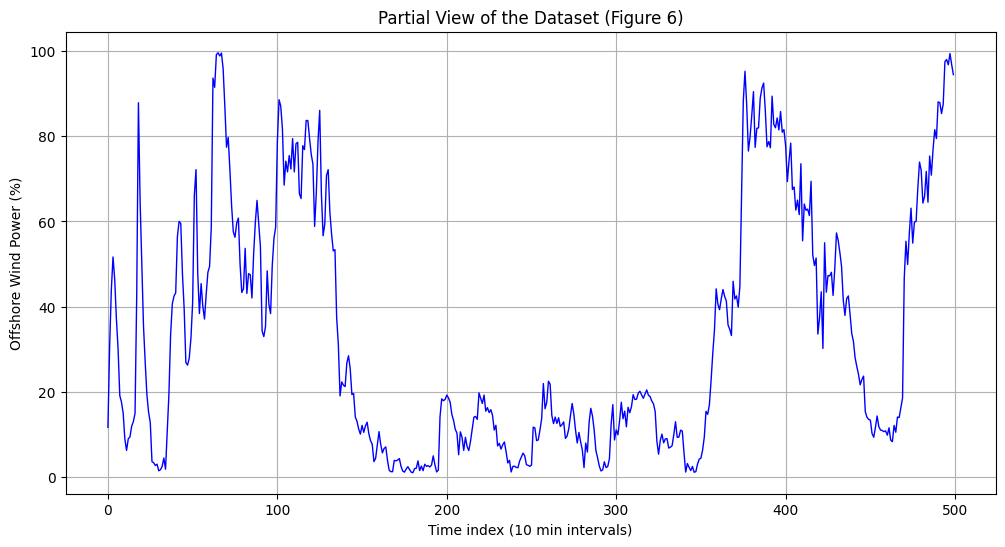

In [ ]:
# Cell 4: Plot Partial View of the Dataset (Figure 6)
fig6_size = min(500, len(y))

plt.figure(figsize=(12, 6))
plt.plot(range(fig6_size), y[:fig6_size], color='blue', linewidth=1)
plt.title("Partial View of the Dataset (Figure 6)")
plt.xlabel("Time index (10 min intervals)")
plt.ylabel("Offshore Wind Power (%)")
plt.grid(True)
plt.show()


Outlier Detection and Plotting (Figure 7)

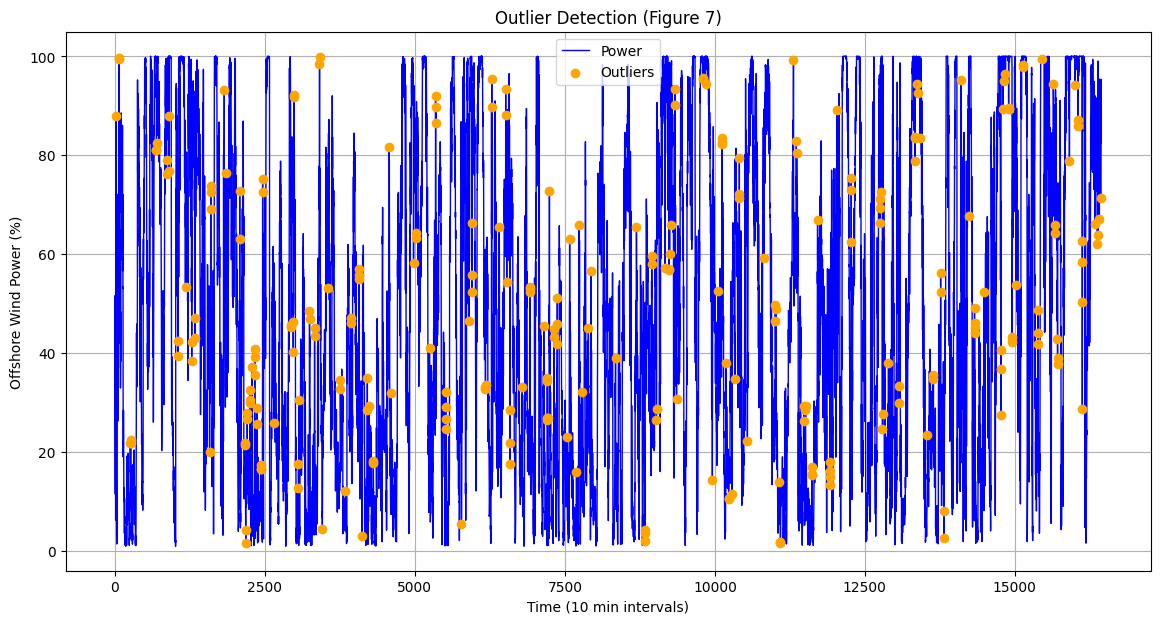

Number of outliers detected: 258


In [ ]:
# Cell 5: Outlier Detection and Plotting (Figure 7)
window_size = 48  # Assuming 48 data points represent 8 hours (48 * 10 minutes)
outliers = []

for i in range(len(y)):
    start = max(0, i - window_size // 2)
    end = min(len(y), i + window_size // 2)
    local_window = y[start:end]
    mean_ = np.mean(local_window)
    var_ = np.var(local_window)
    if abs(y[i] - mean_) > 2 * np.sqrt(var_):  # Threshold of 2 * std
        outliers.append(i)

plt.figure(figsize=(14, 7))
plt.plot(range(len(y)), y, label="Power", color="blue", linewidth=1)
plt.scatter(outliers, y[outliers], color="orange", label="Outliers", zorder=5)
plt.title("Outlier Detection (Figure 7)")
plt.xlabel("Time (10 min intervals)")
plt.ylabel("Offshore Wind Power (%)")
plt.legend()
plt.grid(True)
plt.show()

print(f"Number of outliers detected: {len(outliers)}")


Split Data into Training and Testing Sets

In [ ]:
# Cell 6: Split Data into Training and Testing Sets
train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")


Training samples: 13154, Testing samples: 3289


 Scale Features and Target Variable

In [ ]:
# Cell 7: Scale Features and Target Variable
# Initialize scalers
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit scalers on training data
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)


Define and Train Autoencoder for Denoising

In [ ]:
# Cell 8: Define and Train Autoencoder for Denoising
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=3):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed

# Initialize Autoencoder
input_dim = X_train_scaled.shape[1]
autoencoder = Autoencoder(input_dim, latent_dim=3)
optimizer_ae = optim.Adam(autoencoder.parameters(), lr=0.001)
criterion_ae = nn.MSELoss()

# Prepare data for Autoencoder
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

# Training Autoencoder
epochs_ae = 200
batch_size_ae = 64
train_loader_ae = torch.utils.data.DataLoader(X_train_tensor, batch_size=batch_size_ae, shuffle=True)

autoencoder.train()
for epoch in range(1, epochs_ae + 1):
    epoch_loss = 0
    for batch in train_loader_ae:
        optimizer_ae.zero_grad()
        reconstructed = autoencoder(batch)
        loss = criterion_ae(reconstructed, batch)
        loss.backward()
        optimizer_ae.step()
        epoch_loss += loss.item() * batch.size(0)
    epoch_loss /= len(train_loader_ae.dataset)
    if epoch % 50 == 0 or epoch == 1:
        print(f"Epoch {epoch}/{epochs_ae}, Loss: {epoch_loss:.6f}")


Epoch 1/200, Loss: 0.026472
Epoch 50/200, Loss: 0.009216
Epoch 100/200, Loss: 0.008663
Epoch 150/200, Loss: 0.008493
Epoch 200/200, Loss: 0.008350


Denoise Data Using Autoencoder and Plot (Figure 8)

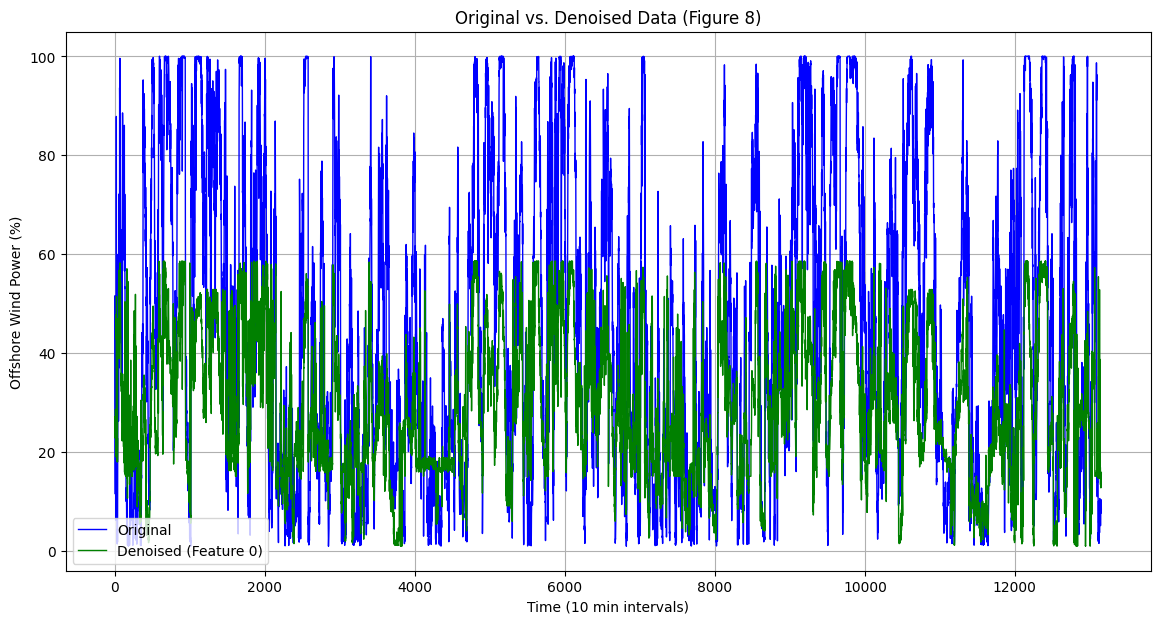

In [ ]:
# Cell 9: Denoise Data Using Autoencoder and Plot (Figure 8)
# Denoise the data
autoencoder.eval()
with torch.no_grad():
    denoised_train = autoencoder(X_train_tensor).numpy()
    denoised_test = autoencoder(X_test_tensor).numpy()

# Optional: Visualize Denoised Data for the First Feature
plt.figure(figsize=(14, 7))
plt.plot(range(len(y_train)), scaler_y.inverse_transform(y_train_scaled), label="Original", color="blue", linewidth=1)
plt.plot(range(len(y_train)), scaler_y.inverse_transform(denoised_train)[:, 0], label="Denoised (Feature 0)", color="green", linewidth=1)
plt.title("Original vs. Denoised Data (Figure 8)")
plt.xlabel("Time (10 min intervals)")
plt.ylabel("Offshore Wind Power (%)")
plt.legend()
plt.grid(True)
plt.show()


Define Model Architectures (MLP, RNN, Transformer)

In [ ]:
# Cell 10: Define Model Architectures (MLP, RNN, Transformer)
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dims=[128, 64], output_dim=1):
        super(MLP, self).__init__()
        layers = []
        prev_dim = input_dim
        for h_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, h_dim))
            layers.append(nn.ReLU())
            prev_dim = h_dim
        layers.append(nn.Linear(prev_dim, output_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, output_dim=1):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers=num_layers, batch_first=True, nonlinearity='relu')
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x: [batch_size, seq_length, input_dim]
        out, _ = self.rnn(x)  # out: [batch_size, seq_length, hidden_dim]
        out = out[:, -1, :]    # Take the output from the last time step
        out = self.fc(out)
        return out

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)  # [max_len, d_model]
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)  # [max_len, 1]
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))  # [d_model/2]
        pe[:, 0::2] = torch.sin(position * div_term)  # Even indices
        pe[:, 1::2] = torch.cos(position * div_term)  # Odd indices
        pe = pe.unsqueeze(0)  # [1, max_len, d_model]
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: [batch_size, seq_length, d_model]
        x = x + self.pe[:, :x.size(1), :]
        return x

class TransformerModel(nn.Module):
    def __init__(self, input_dim, model_dim=64, num_heads=4, num_layers=2, output_dim=1, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.input_fc = nn.Linear(input_dim, model_dim)
        self.pos_encoder = PositionalEncoding(d_model=model_dim)
        encoder_layers = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        self.fc_out = nn.Linear(model_dim, output_dim)

    def forward(self, x):
        # x: [batch_size, seq_length, input_dim]
        x = self.input_fc(x)  # [batch_size, seq_length, model_dim]
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)  # [batch_size, seq_length, model_dim]
        x = x[:, -1, :]  # Take the output from the last time step
        x = self.fc_out(x)
        return x


Define Training and Evaluation Functions

In [ ]:
# Cell 11: Define Training and Evaluation Functions
def train_model(model, dataloader, criterion, optimizer, device, num_epochs=50, early_stopping_patience=10):
    model.to(device)
    best_loss = np.inf
    patience = 0
    for epoch in range(1, num_epochs + 1):
        model.train()
        epoch_loss = 0
        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * X_batch.size(0)
        epoch_loss /= len(dataloader.dataset)

        print(f"Epoch {epoch}/{num_epochs}, Loss: {epoch_loss:.6f}")

        # Early Stopping
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            patience = 0
            best_model_state = model.state_dict()
        else:
            patience += 1
            if patience >= early_stopping_patience:
                print("Early stopping triggered.")
                break
    # Load best model state
    model.load_state_dict(best_model_state)
    return model

def evaluate_model(model, dataloader, device, scaler_y):
    model.eval()
    preds = []
    trues = []
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            preds.append(outputs.cpu().numpy())
            trues.append(y_batch.numpy())
    preds = np.concatenate(preds, axis=0)
    trues = np.concatenate(trues, axis=0)
    # Inverse transform
    preds_inv = scaler_y.inverse_transform(preds)
    trues_inv = scaler_y.inverse_transform(trues)
    # Calculate metrics
    mae = mean_absolute_error(trues_inv, preds_inv)
    rmse = np.sqrt(mean_squared_error(trues_inv, preds_inv))
    # Handle division by zero in MAPE
    nonzero = trues_inv != 0
    mape = np.mean(np.abs((trues_inv[nonzero] - preds_inv[nonzero]) / trues_inv[nonzero])) * 100
    return mae, rmse, mape


In [ ]:
# Cell 12: Prepare Data for Models
# Define batch size and device
batch_size = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create TensorDatasets
# For MLP
dataset_mlp_train = torch.utils.data.TensorDataset(torch.tensor(X_train_scaled, dtype=torch.float32),
                                                  torch.tensor(y_train_scaled, dtype=torch.float32))
dataset_mlp_test = torch.utils.data.TensorDataset(torch.tensor(X_test_scaled, dtype=torch.float32),
                                                 torch.tensor(y_test_scaled, dtype=torch.float32))

dataloader_mlp_train = torch.utils.data.DataLoader(dataset_mlp_train, batch_size=batch_size, shuffle=True)
dataloader_mlp_test = torch.utils.data.DataLoader(dataset_mlp_test, batch_size=batch_size, shuffle=False)

# For RNN and Transformer
# Define sequence length (window size)
seq_length = 10  # Example: use past 10 time steps to predict the next

def create_sequences(X, y, seq_length):
    X_seq = []
    y_seq = []
    for i in range(len(y) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_length)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_length)

dataset_seq_train = torch.utils.data.TensorDataset(torch.tensor(X_train_seq, dtype=torch.float32),
                                                 torch.tensor(y_train_seq, dtype=torch.float32))
dataset_seq_test = torch.utils.data.TensorDataset(torch.tensor(X_test_seq, dtype=torch.float32),
                                                torch.tensor(y_test_seq, dtype=torch.float32))

dataloader_seq_train = torch.utils.data.DataLoader(dataset_seq_train, batch_size=batch_size, shuffle=True)
dataloader_seq_test = torch.utils.data.DataLoader(dataset_seq_test, batch_size=batch_size, shuffle=False)


Using device: cpu


In [ ]:
# Cell 13: Initialize Models
# MLP
mlp = MLP(input_dim=X_train_scaled.shape[1], hidden_dims=[128, 64], output_dim=1)

# RNN
rnn = RNNModel(input_dim=X_train_scaled.shape[1], hidden_dim=64, num_layers=2, output_dim=1)

# Transformer
transformer = TransformerModel(input_dim=X_train_scaled.shape[1], model_dim=64, num_heads=4, num_layers=2, output_dim=1, dropout=0.1)


Define Loss Functions and Optimizers

In [ ]:
# Cell 14: Define Loss Functions and Optimizers
# Define loss functions
criterion_mse = nn.MSELoss()
criterion_huber = nn.HuberLoss(delta=1.0)

# Define optimizers for each model and loss function
optimizer_mlp_mse = optim.Adam(mlp.parameters(), lr=0.001)
optimizer_mlp_huber = optim.Adam(mlp.parameters(), lr=0.001)

optimizer_rnn_mse = optim.Adam(rnn.parameters(), lr=0.001)
optimizer_rnn_huber = optim.Adam(rnn.parameters(), lr=0.001)

optimizer_trans_mse = optim.Adam(transformer.parameters(), lr=0.001)
optimizer_trans_huber = optim.Adam(transformer.parameters(), lr=0.001)


Train Models

In [ ]:
# Cell 15: Train Models
print("\nTraining MLP with MSE Loss:")
mlp_mse = MLP(input_dim=X_train_scaled.shape[1], hidden_dims=[128, 64], output_dim=1)
mlp_mse = train_model(mlp_mse, dataloader_mlp_train, criterion_mse, optimizer_mlp_mse, device, num_epochs=100, early_stopping_patience=10)

print("\nTraining MLP with Huber Loss:")
mlp_huber = MLP(input_dim=X_train_scaled.shape[1], hidden_dims=[128, 64], output_dim=1)
mlp_huber = train_model(mlp_huber, dataloader_mlp_train, criterion_huber, optimizer_mlp_huber, device, num_epochs=100, early_stopping_patience=10)

print("\nTraining RNN with MSE Loss:")
rnn_mse = RNNModel(input_dim=X_train_scaled.shape[1], hidden_dim=64, num_layers=2, output_dim=1)
rnn_mse = train_model(rnn_mse, dataloader_seq_train, criterion_mse, optimizer_rnn_mse, device, num_epochs=100, early_stopping_patience=10)

print("\nTraining RNN with Huber Loss:")
rnn_huber = RNNModel(input_dim=X_train_scaled.shape[1], hidden_dim=64, num_layers=2, output_dim=1)
rnn_huber = train_model(rnn_huber, dataloader_seq_train, criterion_huber, optimizer_rnn_huber, device, num_epochs=100, early_stopping_patience=10)

print("\nTraining Transformer with MSE Loss:")
transformer_mse = TransformerModel(input_dim=X_train_scaled.shape[1], model_dim=64, num_heads=4, num_layers=2, output_dim=1, dropout=0.1)
transformer_mse = train_model(transformer_mse, dataloader_seq_train, criterion_mse, optimizer_trans_mse, device, num_epochs=100, early_stopping_patience=10)

print("\nTraining Transformer with Huber Loss:")
transformer_huber = TransformerModel(input_dim=X_train_scaled.shape[1], model_dim=64, num_heads=4, num_layers=2, output_dim=1, dropout=0.1)
transformer_huber = train_model(transformer_huber, dataloader_seq_train, criterion_huber, optimizer_trans_huber, device, num_epochs=100, early_stopping_patience=10)



Training MLP with MSE Loss:
Epoch 1/100, Loss: 0.163037
Epoch 2/100, Loss: 0.163037
Epoch 3/100, Loss: 0.163037
Epoch 4/100, Loss: 0.163037
Epoch 5/100, Loss: 0.163037
Epoch 6/100, Loss: 0.163037
Epoch 7/100, Loss: 0.163037
Epoch 8/100, Loss: 0.163037
Epoch 9/100, Loss: 0.163037
Epoch 10/100, Loss: 0.163037
Epoch 11/100, Loss: 0.163037
Epoch 12/100, Loss: 0.163037
Epoch 13/100, Loss: 0.163037
Epoch 14/100, Loss: 0.163037
Epoch 15/100, Loss: 0.163037
Epoch 16/100, Loss: 0.163037
Epoch 17/100, Loss: 0.163037
Epoch 18/100, Loss: 0.163037
Epoch 19/100, Loss: 0.163037
Epoch 20/100, Loss: 0.163037
Epoch 21/100, Loss: 0.163037
Epoch 22/100, Loss: 0.163037
Early stopping triggered.

Training MLP with Huber Loss:
Epoch 1/100, Loss: 0.117984
Epoch 2/100, Loss: 0.117984
Epoch 3/100, Loss: 0.117984
Epoch 4/100, Loss: 0.117984
Epoch 5/100, Loss: 0.117984
Epoch 6/100, Loss: 0.117984
Epoch 7/100, Loss: 0.117984
Epoch 8/100, Loss: 0.117984
Epoch 9/100, Loss: 0.117984
Epoch 10/100, Loss: 0.117984
Epoc

Evaluate Models

In [ ]:
# Cell 16: Evaluate Models
print("\nEvaluating Models:")

# MLP with MSE
mae_mlp_mse, rmse_mlp_mse, mape_mlp_mse = evaluate_model(mlp_mse, dataloader_mlp_test, device, scaler_y)

# MLP with Huber
mae_mlp_huber, rmse_mlp_huber, mape_mlp_huber = evaluate_model(mlp_huber, dataloader_mlp_test, device, scaler_y)

# RNN with MSE
mae_rnn_mse, rmse_rnn_mse, mape_rnn_mse = evaluate_model(rnn_mse, dataloader_seq_test, device, scaler_y)

# RNN with Huber
mae_rnn_huber, rmse_rnn_huber, mape_rnn_huber = evaluate_model(rnn_huber, dataloader_seq_test, device, scaler_y)

# Transformer with MSE
mae_trans_mse, rmse_trans_mse, mape_trans_mse = evaluate_model(transformer_mse, dataloader_seq_test, device, scaler_y)

# Transformer with Huber
mae_trans_huber, rmse_trans_huber, mape_trans_huber = evaluate_model(transformer_huber, dataloader_seq_test, device, scaler_y)

# Compile Results
results_single_step = [
    ["MLP", "MSE", mae_mlp_mse, rmse_mlp_mse, mape_mlp_mse],
    ["MLP", "Huber", mae_mlp_huber, rmse_mlp_huber, mape_mlp_huber],
    ["RNN", "MSE", mae_rnn_mse, rmse_rnn_mse, mape_rnn_mse],
    ["RNN", "Huber", mae_rnn_huber, rmse_rnn_huber, mape_rnn_huber],
    ["Transformer", "MSE", mae_trans_mse, rmse_trans_mse, mape_trans_mse],
    ["Transformer", "Huber", mae_trans_huber, rmse_trans_huber, mape_trans_huber]
]

df_results = pd.DataFrame(results_single_step, columns=["Architecture", "LossFunction", "MAE", "RMSE", "MAPE(%)"])

print("\nSingle-Step Forecasting Results (Similar to Table 3):")
print(df_results.to_string(index=False))



Evaluating Models:

Single-Step Forecasting Results (Similar to Table 3):
Architecture LossFunction        MAE       RMSE    MAPE(%)
         MLP          MSE  44.468124  53.142077  83.250463
         MLP        Huber  53.690323  62.703218  80.746663
         RNN          MSE  65.291916  73.076346 114.712727
         RNN        Huber  66.915398  74.773731 118.532419
 Transformer          MSE 156.284012 160.798538 432.897997
 Transformer        Huber  82.544548  88.600049 180.854166


Hyperparameter Optimization with Slime Mould Algorithm

In [ ]:
# Cell 18: (Optional) Hyperparameter Optimization with Slime Mould Algorithm
class SlimeMouldAlgorithm:
    def __init__(self, func, n_dim, n_agents, max_iter, bounds):
        self.func = func
        self.n_dim = n_dim
        self.n_agents = n_agents
        self.max_iter = max_iter
        self.bounds = bounds

        self.population = np.zeros((n_agents, n_dim))
        for i in range(n_agents):
            for j in range(n_dim):
                low, high = bounds[j]
                self.population[i, j] = np.random.uniform(low, high)

        self.fitness = np.full(n_agents, float('inf'))
        self.best_fitness = float('inf')
        self.best_agent = np.zeros(n_dim)

    def run(self):
        t = 0
        while t < self.max_iter:
            for i in range(self.n_agents):
                self.fitness[i] = self.func(self.population[i])

            min_idx = np.argmin(self.fitness)
            if self.fitness[min_idx] < self.best_fitness:
                self.best_fitness = self.fitness[min_idx]
                self.best_agent = self.population[min_idx].copy()

            sorted_idx = np.argsort(self.fitness)
            S = np.zeros(self.n_agents)
            for i in range(self.n_agents):
                rank = np.where(sorted_idx == i)[0][0]
                S[i] = (self.n_agents - rank) / self.n_agents

            a = 2 * (1 - (t / self.max_iter))
            for i in range(self.n_agents):
                r = np.random.rand()
                vb = a * (2*r - 1)
                W = S[i] * (1 - (t/self.max_iter)) + vb

                if S[i] < 0.5:
                    for d in range(self.n_dim):
                        if abs(W) >= 1:
                            low, high = self.bounds[d]
                            self.population[i, d] = np.random.uniform(low, high)
                        else:
                            best_d = self.best_agent[d]
                            cur_d = self.population[i, d]
                            self.population[i, d] = best_d - W * abs(best_d - cur_d)
                        # Clip
                        self.population[i, d] = np.clip(
                            self.population[i, d],
                            self.bounds[d][0],
                            self.bounds[d][1]
                        )
                else:
                    idx_rand = np.random.randint(self.n_agents)
                    for d in range(self.n_dim):
                        peer_d = self.population[idx_rand, d]
                        self.population[i, d] = self.population[i, d] - W * (self.population[i, d] - peer_d)
                        self.population[i, d] = np.clip(
                            self.population[i, d],
                            self.bounds[d][0],
                            self.bounds[d][1]
                        )
            t += 1
        return self.best_agent

def transformer_objective(params):
    n_layers = int(params[0])
    lr = params[1]

    model = TransformerModel(input_dim=X_train_scaled.shape[1], model_dim=64, num_heads=4, num_layers=n_layers, output_dim=1, dropout=0.1)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model = train_model(model, dataloader_seq_train, criterion_mse, optimizer, device, num_epochs=10, early_stopping_patience=5)
    mae, _, _ = evaluate_model(model, dataloader_seq_test, device, scaler_y)
    return mae

search_space = [
    (1, 5),        # n_layers from 1..5
    (0.0001, 0.01) # lr from 1e-4..1e-2
]

sma = SlimeMouldAlgorithm(
    func=transformer_objective,
    n_dim=2,
    n_agents=5,
    max_iter=5,
    bounds=search_space
)

best_params_sma = sma.run()
print("\nBest Transformer Hyperparams [n_layers, lr]:", best_params_sma)


Epoch 1/10, Loss: 0.239530
Epoch 2/10, Loss: 0.023382
Epoch 3/10, Loss: 0.012431
Epoch 4/10, Loss: 0.011242
Epoch 5/10, Loss: 0.011681
Epoch 6/10, Loss: 0.011204
Epoch 7/10, Loss: 0.011705
Epoch 8/10, Loss: 0.010949
Epoch 9/10, Loss: 0.010915
Epoch 10/10, Loss: 0.011076
Epoch 1/10, Loss: 0.095346
Epoch 2/10, Loss: 0.014766
Epoch 3/10, Loss: 0.012971
Epoch 4/10, Loss: 0.012368
Epoch 5/10, Loss: 0.012265
Epoch 6/10, Loss: 0.011839
Epoch 7/10, Loss: 0.012083
Epoch 8/10, Loss: 0.012018
Epoch 9/10, Loss: 0.011192
Epoch 10/10, Loss: 0.011610
Epoch 1/10, Loss: 0.154938
Epoch 2/10, Loss: 0.061146
Epoch 3/10, Loss: 0.015542
Epoch 4/10, Loss: 0.014914
Epoch 5/10, Loss: 0.012512
Epoch 6/10, Loss: 0.012259
Epoch 7/10, Loss: 0.012184
Epoch 8/10, Loss: 0.011606
Epoch 9/10, Loss: 0.012012
Epoch 10/10, Loss: 0.011515
Epoch 1/10, Loss: 0.219649
Epoch 2/10, Loss: 0.048890
Epoch 3/10, Loss: 0.014779
Epoch 4/10, Loss: 0.012894
Epoch 5/10, Loss: 0.013310
Epoch 6/10, Loss: 0.012140
Epoch 7/10, Loss: 0.01189

Multi-Step Forecasting

In [26]:
# Modified Transformer Model Class for Multi-Step Forecasting
class TransformerModel(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_layers, output_dim, dropout):
        super(TransformerModel, self).__init__()
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, dropout=dropout),
            num_layers=num_layers
        )
        self.fc_in = nn.Linear(input_dim, model_dim)  # Project input to model_dim
        self.fc_out = nn.Linear(model_dim, output_dim)  # Project to output_dim (horizon)

    def forward(self, x):
        x = self.fc_in(x)  # Shape: (batch_size, seq_length, model_dim)
        x = x.permute(1, 0, 2)  # Shape: (seq_length, batch_size, model_dim)
        x = self.encoder(x)  # Shape: (seq_length, batch_size, model_dim)
        x = x[-1]  # Use the output at the last time step
        return self.fc_out(x)  # Shape: (batch_size, horizon)

# Function for Multi-Step Forecasting Sequences
def create_multi_step_sequences(X, y, horizon, seq_length):
    X_seq = []
    y_seq = []
    for i in range(len(y) - seq_length - horizon + 1):
        X_seq.append(X[i:i+seq_length])  # Input sequence of length seq_length
        y_seq.append(y[i+seq_length:i+seq_length+horizon].flatten())  # Target sequence of length horizon
    return np.array(X_seq), np.array(y_seq)

# Initialize Parameters
time_steps = [4, 8, 16]  # Corresponding to t+4, t+8, t+16
multi_step_results = []

best_n_layers = int(best_params_sma[0])
best_lr = best_params_sma[1]

for horizon in time_steps:
    X_train_multi, y_train_multi = create_multi_step_sequences(X_train_scaled, y_train_scaled, horizon, seq_length)
    X_test_multi, y_test_multi = create_multi_step_sequences(X_test_scaled, y_test_scaled, horizon, seq_length)

    # Convert to PyTorch Datasets and DataLoaders
    dataset_multi_train = torch.utils.data.TensorDataset(torch.tensor(X_train_multi, dtype=torch.float32),
                                                         torch.tensor(y_train_multi, dtype=torch.float32))
    dataset_multi_test = torch.utils.data.TensorDataset(torch.tensor(X_test_multi, dtype=torch.float32),
                                                        torch.tensor(y_test_multi, dtype=torch.float32))

    dataloader_multi_train = torch.utils.data.DataLoader(dataset_multi_train, batch_size=batch_size, shuffle=True)
    dataloader_multi_test = torch.utils.data.DataLoader(dataset_multi_test, batch_size=batch_size, shuffle=False)

    # Initialize Transformer Model
    transformer_multi = TransformerModel(
        input_dim=X_train_multi.shape[2],
        model_dim=64,
        num_heads=4,
        num_layers=best_n_layers,
        output_dim=horizon,
        dropout=0.1
    ).to(device)

    # Define Loss Function and Optimizer
    criterion_multi = nn.MSELoss()
    optimizer_multi = optim.Adam(transformer_multi.parameters(), lr=best_lr)

    # Train the Model
    transformer_multi = train_model(
        transformer_multi,
        dataloader_multi_train,
        criterion_multi,
        optimizer_multi,
        device,
        num_epochs=100,
        early_stopping_patience=10
    )

    # Evaluate the Model
    mae_multi, rmse_multi, mape_multi = evaluate_model(
        transformer_multi,
        dataloader_multi_test,
        device,
        scaler_y
    )

    # Store Results
    minutes_ahead = horizon * 10
    multi_step_results.append({
        "Time Step": f"t+{horizon} ({minutes_ahead} min)",
        "MAE": mae_multi,
        "RMSE": rmse_multi,
        "MAPE": mape_multi
    })

# Create and Display Results DataFrame
df_multi_step = pd.DataFrame(multi_step_results)
print("Multi-Step Forecasting Results (Similar to Table 4):")
print(df_multi_step.to_string(index=False))


Epoch 1/100, Loss: 0.067504
Epoch 2/100, Loss: 0.012403
Epoch 3/100, Loss: 0.011340
Epoch 4/100, Loss: 0.010778
Epoch 5/100, Loss: 0.010715
Epoch 6/100, Loss: 0.010285
Epoch 7/100, Loss: 0.010095
Epoch 8/100, Loss: 0.010213
Epoch 9/100, Loss: 0.009690
Epoch 10/100, Loss: 0.009972
Epoch 11/100, Loss: 0.009846
Epoch 12/100, Loss: 0.009509
Epoch 13/100, Loss: 0.009470
Epoch 14/100, Loss: 0.009860
Epoch 15/100, Loss: 0.009548
Epoch 16/100, Loss: 0.009301
Epoch 17/100, Loss: 0.009453
Epoch 18/100, Loss: 0.009135
Epoch 19/100, Loss: 0.009140
Epoch 20/100, Loss: 0.008954
Epoch 21/100, Loss: 0.008892
Epoch 22/100, Loss: 0.009056
Epoch 23/100, Loss: 0.008876
Epoch 24/100, Loss: 0.009176
Epoch 25/100, Loss: 0.008737
Epoch 26/100, Loss: 0.008730
Epoch 27/100, Loss: 0.008999
Epoch 28/100, Loss: 0.008877
Epoch 29/100, Loss: 0.008546
Epoch 30/100, Loss: 0.008799
Epoch 31/100, Loss: 0.008559
Epoch 32/100, Loss: 0.008631
Epoch 33/100, Loss: 0.008613
Epoch 34/100, Loss: 0.008411
Epoch 35/100, Loss: 0.0

Visualize Multi-Step Forecasting Results

In [27]:
# Cell 20: (Optional) Visualize Multi-Step Forecasting Results
for result in multi_step_results:
    horizon = result["Time Step"]
    mae = result["MAE"]
    rmse = result["RMSE"]
    mape = result["MAPE"]
    print(f"{horizon}: MAE={mae:.4f}, RMSE={rmse:.4f}, MAPE={mape:.2f}%")


t+4 (40 min): MAE=7.9900, RMSE=12.8225, MAPE=29.58%
t+8 (80 min): MAE=11.2844, RMSE=16.7441, MAPE=41.76%
t+16 (160 min): MAE=16.0006, RMSE=22.8267, MAPE=63.12%
